# Multilayer Perceptron (Taxi Data)

This notebook provides code to training and evaluating a multilayer perceptron on a dataset of downsampled runway images with labeled position and orientation.

## Imports and Device

In [26]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import h5py

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Load in the Data

In [109]:
resolution = 64

if resolution == 64:
    with h5py.File("data/runway_images_64.h5", "r") as f:
        images = f['X_train'][:]
        labels = f['y_train'][:][:, 4:6]
    # shuffle data
    idx = np.random.permutation(len(images))
    images, labels = images[idx], labels[idx]
    # split data
    split = int(len(images) * 0.8)
    images_train, images_test = images[:split], images[split:]
    labels_train, labels_test = labels[:split], labels[split:]
else:
    with h5py.File("data/runway_images.h5", "r") as f:
        images_train = f['X_train'][:]
        images_test = f['X_val'][:]
        labels_train = f['y_train'][:]
        labels_test = f['y_val'][:]

In [110]:
print('Number of training images:', images_train.shape[0])
print('Number of test images:', images_test.shape[0])

Number of training images: 8000
Number of test images: 2000


### Visualize

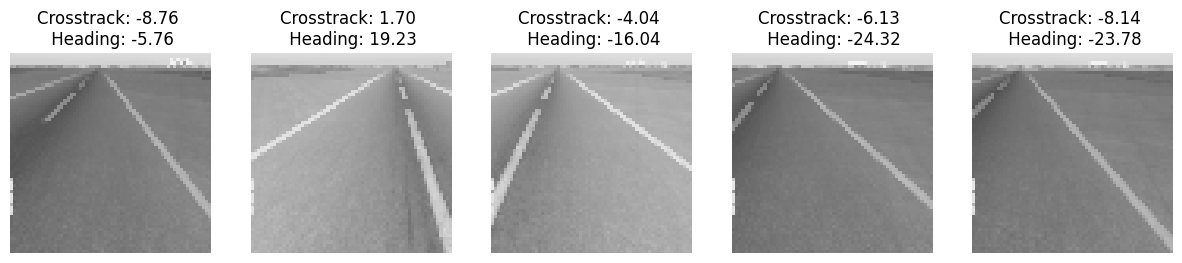

In [111]:
def plot_five_random(images, labels):
    random_indexes = np.random.randint(0, images.shape[0], 5)
    images = images[random_indexes]
    labels = labels[random_indexes]

    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i], cmap='gray', clim=(0,1))
        plt.title(f'Crosstrack: {labels[i][0]:.2f} \n Heading: {labels[i][1]:.2f}')
        plt.axis('off')

plot_five_random(images_train, labels_train)

## Custom Dataset

In [112]:
class RunwayDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image).float(), torch.tensor(label).float()

In [113]:
train_dataset = RunwayDataset(images_train, labels_train)
test_dataset = RunwayDataset(images_test, labels_test)

## Define the MLP Architecture

In [120]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.view(-1, input_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [126]:
input_dim = 64 * 64 if resolution == 64 else 16 * 8
model = MLP(input_dim)
print(model)

MLP(
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


## Loss Function and Optimizer

In [127]:
loss = nn.MSELoss()
alpha = 0.0001 if resolution == 64 else 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

## Training

In [128]:
NUM_EPOCHS = 500 if resolution == 64 else 100
BATCH_SIZE = 256
PRINT_EVERY = 10 if resolution == 64 else 1

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    valid_loss = 0.0

    # Training
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss_value = loss(outputs, labels)
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item()*images.size(0)

    # Validation
    for images, labels in valid_loader:
        outputs = model(images)
        loss_value = loss(outputs, labels)
        valid_loss += loss_value.item()*images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    if epoch % PRINT_EVERY == 0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

Epoch: 0, Train Loss: 165.4797, Valid Loss: 168.0324
Epoch: 10, Train Loss: 164.9450, Valid Loss: 167.5042
Epoch: 20, Train Loss: 163.8436, Valid Loss: 166.3816
Epoch: 30, Train Loss: 160.4928, Valid Loss: 162.9199
Epoch: 40, Train Loss: 146.1568, Valid Loss: 147.9113
Epoch: 50, Train Loss: 111.0922, Valid Loss: 114.0285
Epoch: 60, Train Loss: 90.3922, Valid Loss: 99.1496
Epoch: 70, Train Loss: 80.3776, Valid Loss: 77.9675
Epoch: 80, Train Loss: 78.0038, Valid Loss: 97.8377
Epoch: 90, Train Loss: 70.3077, Valid Loss: 103.6956
Epoch: 100, Train Loss: 56.8790, Valid Loss: 70.2633
Epoch: 110, Train Loss: 43.8335, Valid Loss: 52.6331
Epoch: 120, Train Loss: 39.4814, Valid Loss: 43.4057
Epoch: 130, Train Loss: 32.7570, Valid Loss: 22.9430
Epoch: 140, Train Loss: 27.8024, Valid Loss: 18.1819
Epoch: 150, Train Loss: 30.1979, Valid Loss: 19.1833
Epoch: 160, Train Loss: 23.2832, Valid Loss: 35.7153
Epoch: 170, Train Loss: 17.4419, Valid Loss: 20.2697
Epoch: 180, Train Loss: 19.8619, Valid Loss:

## Plot Results

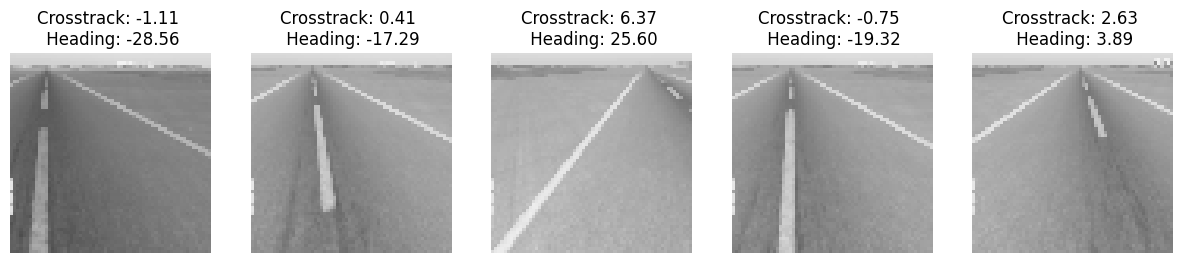

In [129]:
def plot_five_outputs(dataset):
    random_indexes = np.random.randint(0, len(dataset), 5)
    images = [dataset[i][0] for i in random_indexes]
    labels = model(torch.stack(images))

    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray', clim=(0,1))
        plt.title(f'Crosstrack: {labels[i][0]:.2f} \n Heading: {labels[i][1]:.2f}')
        plt.axis('off')

plot_five_outputs(test_dataset)

In [130]:
preds = model(torch.stack([test_dataset[i][0] for i in range(len(test_dataset))]))
preds = preds.detach().numpy()
labels = np.array([test_dataset[i][1] for i in range(len(test_dataset))])
errors = preds - labels
crosstrack_errors = errors[:, 0]
heading_errors = errors[:, 1]

print('Mean crosstrack error:', np.mean(crosstrack_errors), 'meters')
print('Mean heading error:', np.mean(heading_errors), 'degrees')

Mean crosstrack error: -0.31527415 meters
Mean heading error: 0.9350755 degrees


Text(0, 0.5, 'Frequency')

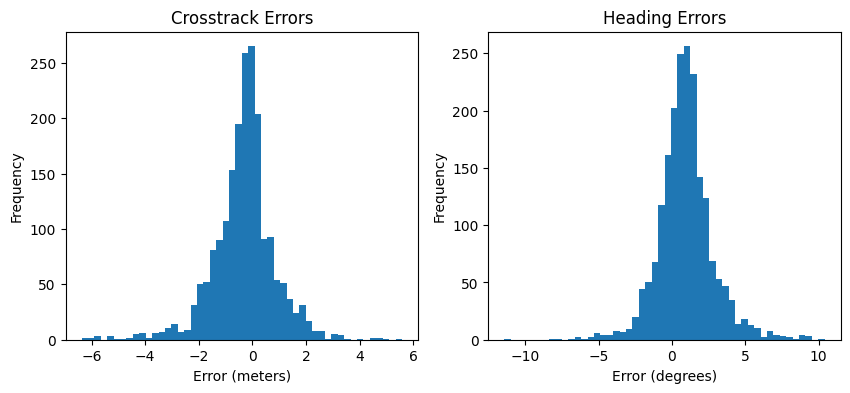

In [131]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(crosstrack_errors, bins=50)
plt.title('Crosstrack Errors')
plt.xlabel('Error (meters)')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(heading_errors, bins=50)
plt.title('Heading Errors')
plt.xlabel('Error (degrees)')
plt.ylabel('Frequency')